In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('ggplot')

# TP: Support Vector Machine (SVM)

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

<div class='alert alert-block alert-warning'>
            Answer:</div>

            

The primal problem associated with SVM is the following :
            $$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R}, \xi \in \mathbb{R}^d } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n \xi _i \right) $$ with $$\forall i ,\xi _i \geq 0,  y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 ) \leq 1-\xi _i $$
 We can go from one solution to another letting $\xi _i= [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+$ with w,b being solution of the above primal problem

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

<div class='alert alert-block alert-warning'>
            Answer:</div>
            Hence Hinge is convex, SVM minimizes the sums of convex upper bound, looking at the problem above, giving us a unique solution to our problem.
            The pivotal loss is always superior to those of the binary classification

## Example of using the SVC class from scikit-learn

In [10]:
#  Data Generation

def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

Training score : 1.0
Testing score : 0.9


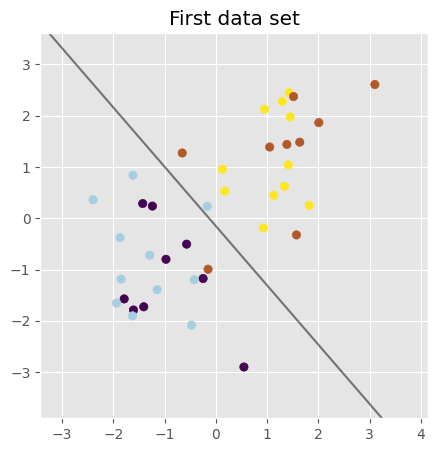

In [11]:
# This is an example of using SVC for data generated with the above function
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score_train = clf.score(X_train, Y_train)
score_test = clf.score(X_test, Y_test)
print('Training score : %s' % score_train)
print('Testing score : %s' % score_test)

# display the points
plt.figure(1, figsize=(5, 5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X1,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    ax=ax,
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.Paired)
plt.title('First data set')
plt.axis('equal')
plt.show()

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distributions : each class is a Gaussian with specific parameters. This time, use the function ```make_blobs``` available in ```sklearn.datasets``` library. Reserve 75% of the data for training and 25% for the test data.

<div class='alert alert-block alert-info'>
            Code:</div>

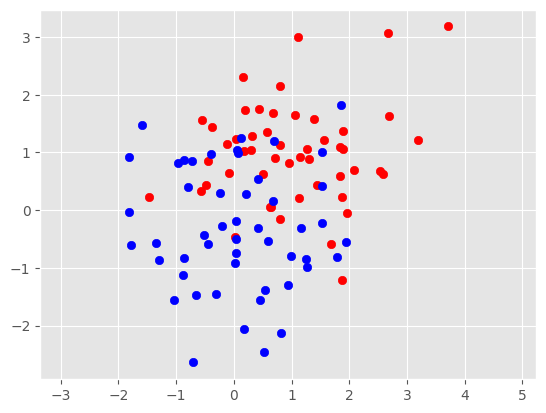

In [12]:
# Create two centers for the two distributions 
centers = [[0,0],[1,1]]

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(n_samples=100, centers=centers)

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

In [13]:
# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, test_size=0.25, random_state=42)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [14]:
from scipy.stats import multivariate_normal
from random import randint
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# You need to use the imported class from scipy to generate a large number of samples which you will use 
# to approximate the integral of the Bayes risk
n_mc = 10 # Repeat this n_mc times - enough to approximate 
expectation = 0
for i in range(n_mc):
    rand = randint(0,len(y_train))  # Random binary choice: will the point be generated from the first or second gaussian ? 
    y=y_train[rand]
    if y==0:
        # First case: y = 0
        x = np.random.multivariate_normal(mean=centers[0],cov=np.eye(2))
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal(mean=centers[1],cov=np.eye(2))

    # You have to compute the conditional posterior probability of x given the 2 gaussians 
    # Use the multivariate_normal.pdf() method !    
    p1 = multivariate_normal.pdf(x,centers[0])
    p2 = multivariate_normal.pdf(x,centers[1])
    # Compute the risk from these and add it to the total
    PY=np.mean(y_train)
    R1bayes=1 if p1*PY/((1-PY)*p2+PY*p1)>1/2 else 0
    
    expectation += R1bayes

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')

Estimated Bayes risk: 0.3
Estimated Bayes accuracy: 0.7


**5)** Draw the decision boundary $H$ induced by SVM as well as the hyperplanes $H_1$ and $H_{−1}$. Vary the parameter C to see its impact on the number of support vectors. We can use the code in the following example: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

<div class='alert alert-block alert-info'>
            Code:</div>

Train/Test scores: 0.84/0.68


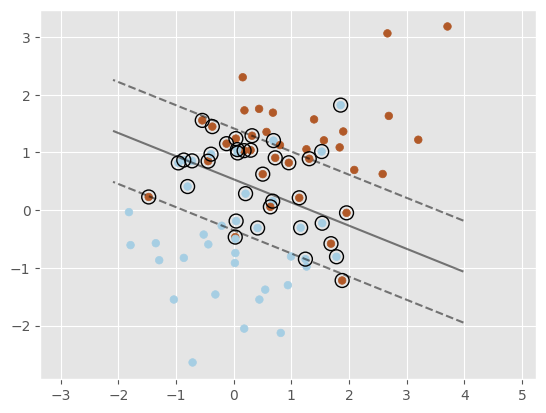

In [15]:
# Create a linear SVM and train it on the training data
clf = svm.SVC(kernel='linear',C=1).fit(X_train,y_train)
print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation (for example, using the function ```GridSearchCV```) to find the optimal parameter $C∗$ to classify this new dataset using a linear kernel.

<div class='alert alert-block alert-info'>
            Code:</div>

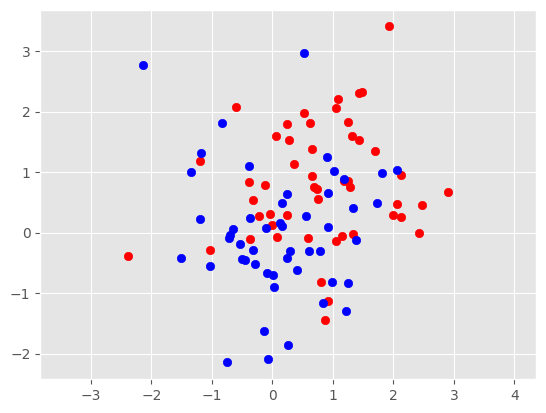

Train/Test scores: 0.84/0.68


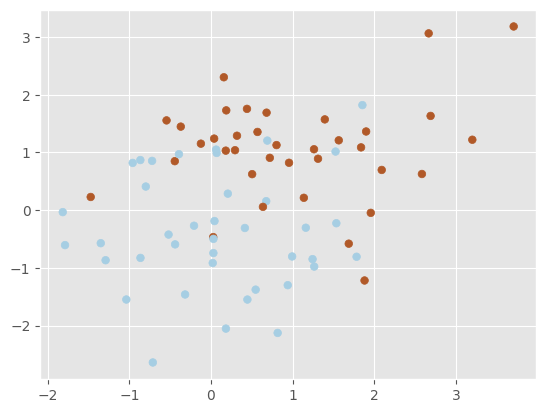

In [16]:
# Generate data and verify graphically that the two classes overlap
# Re-use the code from question 3 and 5

# Create two centers for the two distributions 
centers = [[0,0],[1,1]]

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(n_samples=100, centers=centers)

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

# Create a linear SVM and train it on the training data
clf = svm.SVC(kernel='linear',C=1).fit(X_train,y_train)
print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

In [17]:
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)
best_params = clf.best_params_
best_estimator = clf.best_estimator_

# Evaluate best model
best_model_score = best_estimator.score(X_test, y_test)

print("Best Parameters:", best_params)
print("Best Model Score:", best_model_score)


Best Parameters: {'C': 0.03162277660168379, 'kernel': 'linear'}
Best Model Score: 0.68


**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore $\gamma$ and $C$), can lead to overfitting.

<div class='alert alert-block alert-info'>
            Code:</div>

In [18]:

# Create a gaussian svm and vary the parameter of the kernel, check the difference between training and testing scores

# Define parameter grid
gammas = [0.1, 1, 10, 100]
parameters = {'C': list(np.logspace(-3, 3, 5)),
              'gamma':gammas}

# Instantiate SVM classifier with RBF kernel
svm = SVC(kernel='rbf')

# Instantiate GridSearchCV
grid_search = GridSearchCV(svm, parameters , cv=5, scoring='accuracy',return_train_score=True)

# Fit GridSearchCV object
grid_search.fit(X_train, y_train)

# Access best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Evaluate best model on test data
test_score = best_estimator.score(X_test, y_test)
train_score = best_estimator.score(X_train, y_train)

# Access CV results
cv_results = grid_search.cv_results_

# Print test accuracies for each parameter combination
for mean_train_score, mean_test_score, params in zip(cv_results['mean_train_score'], cv_results['mean_test_score'], cv_results['params']):
    print("Training Accuracy:", mean_train_score, "Test Accuracy:", mean_test_score,"with Parameters:", params )

Training Accuracy: 0.52 Test Accuracy: 0.5199999999999999 with Parameters: {'C': 0.001, 'gamma': 0.1}
Training Accuracy: 0.52 Test Accuracy: 0.5199999999999999 with Parameters: {'C': 0.001, 'gamma': 1}
Training Accuracy: 0.52 Test Accuracy: 0.5199999999999999 with Parameters: {'C': 0.001, 'gamma': 10}
Training Accuracy: 0.52 Test Accuracy: 0.5199999999999999 with Parameters: {'C': 0.001, 'gamma': 100}
Training Accuracy: 0.52 Test Accuracy: 0.5199999999999999 with Parameters: {'C': 0.03162277660168379, 'gamma': 0.1}
Training Accuracy: 0.52 Test Accuracy: 0.5199999999999999 with Parameters: {'C': 0.03162277660168379, 'gamma': 1}
Training Accuracy: 0.52 Test Accuracy: 0.5199999999999999 with Parameters: {'C': 0.03162277660168379, 'gamma': 10}
Training Accuracy: 0.52 Test Accuracy: 0.5199999999999999 with Parameters: {'C': 0.03162277660168379, 'gamma': 100}
Training Accuracy: 0.8366666666666666 Test Accuracy: 0.8133333333333332 with Parameters: {'C': 1.0, 'gamma': 0.1}
Training Accuracy: 0

We clearly overfitting for C= 1 and $\gamma$= 100

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function ```make_blobs``` available in ```sklearn.datasetslibrary``` ).

<div class='alert alert-block alert-info'>
            Code:</div>

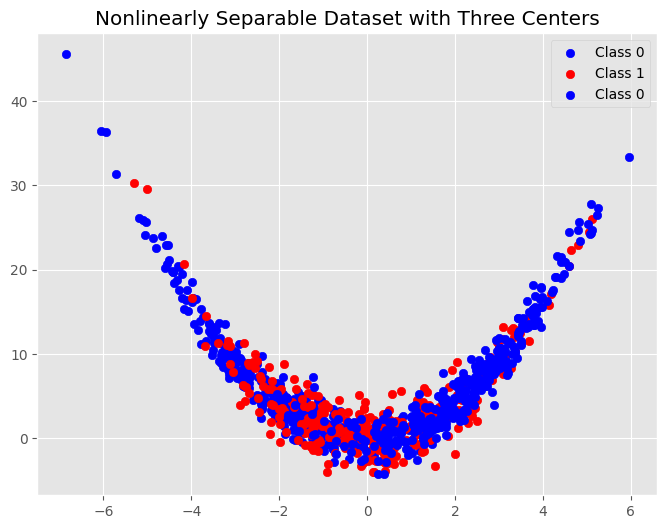

In [19]:
# Use make blobs with three centers which are aligned, for example
# Class 0 - Class 1 - Class 0 

# Define parameters for the synthetic dataset
n_samples = 1000
centers = [[-2, 0], [0, 0], [2, 0]]     
cluster_std = [1.5, 2, 1.5]  # Standard deviation of the clusters

# Generate the synthetic dataset
X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=42)

# Transform the dataset to make it nonlinearly separable
X[:, 1] = X[:, 1] + (X[:, 0]**2)  # Adding a nonlinear transformation to the second feature

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], color='blue', label='Class 0')
plt.title('Nonlinearly Separable Dataset with Three Centers')
plt.legend()
plt.grid(True)
plt.show()


**9)** Use an SVM with a linear kernel then a Gaussian (with well-adapted parameters, that you can obtain using, again, ```GridSearchCV```) then plot the decision boundaries of these algorithms on separate graphs.

<div class='alert alert-block alert-info'>
            Code:</div>

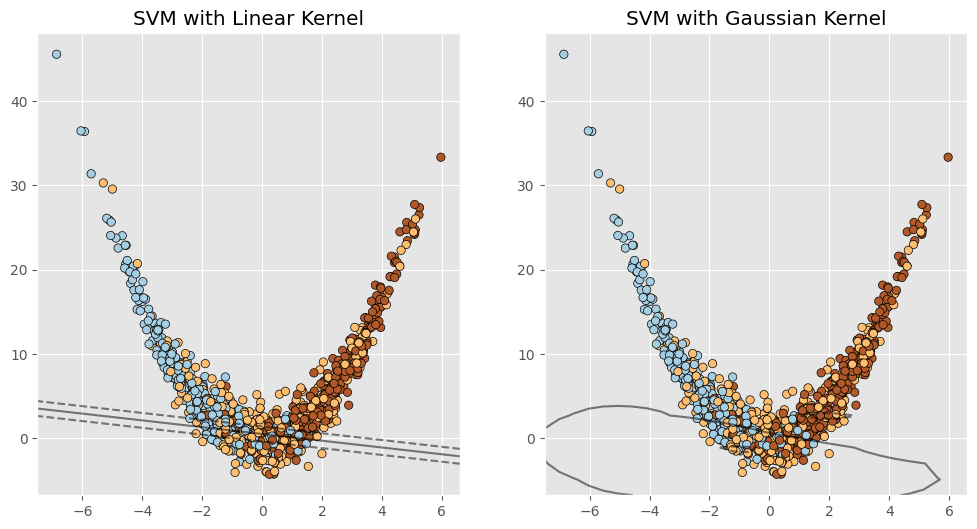

In [20]:
# Define parameter grid for Gaussian kernel
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1]}

# Instantiate SVM classifier with linear kernel
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

# Instantiate SVM classifier with Gaussian kernel
svm_rbf = SVC(kernel='rbf')
grid_search = GridSearchCV(svm_rbf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Plot decision boundaries
plt.figure(figsize=(12, 6))

# Plot decision boundary for SVM with linear kernel
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z_linear = svm_linear.decision_function(xy).reshape(XX.shape)

# Plot decision boundary
plt.contour(XX, YY, Z_linear, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
plt.title('SVM with Linear Kernel')

# Plot decision boundary for SVM with Gaussian kernel
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z_rbf = grid_search.best_estimator_.decision_function(xy).reshape(XX.shape)

# Plot decision boundary
plt.contour(XX, YY, Z_rbf, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
plt.title('SVM with Gaussian Kernel')


plt.show()

## Learning curve

**10)** Draw the learning curve of the algorithm : with fixed hyper-parameters and a fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). For each size, repeat the experiment a large number of times to average the performance. 
Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

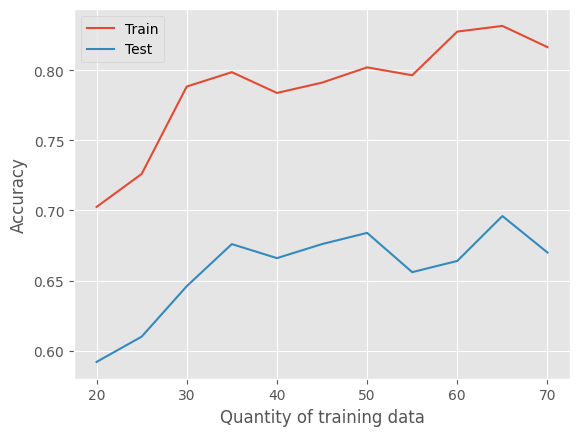

In [21]:
# Total number of training samples
n_tr = len(X_train)

# Repeat the experiment for all these training sizes
sizes = np.arange(20, n_tr, 5)

# Repeat each experiment this many times 
n_m = 20  

# Store scores in these lists
scores_train = []
scores_test = []

# Main loop: varying the training size
for size in sizes:
    score_train = 0
    score_test = 0
    # Second loop: repeating the experiment for each size
    for i in range(n_m):
        # Create a SVM, keeping the same parameters
        clf = SVC(kernel='linear', C=0.031)
        # For each experiment, draw a subset of the training data of the appropriate size
        idx = np.random.choice(range(n_tr), size=size)
        X_train_reduced = X_train[idx, :]
        y_train_reduced = y_train[idx]
        
        # Fit the classifier and compute the scores on training and test data
        clf.fit(X_train_reduced, y_train_reduced)
        score_train += clf.score(X_train_reduced, y_train_reduced)
        score_test += clf.score(X_test, y_test)
    # Add the average of the scores to the lists
    scores_train.append(score_train / n_m)
    scores_test.append(score_test / n_m)

# Plot the results
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [22]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# This is the same computation than in question 4). 
n_mc = 20 # Repeat this n_mc times - enough to approximate 
expectation = 0
for i in range(n_mc):
    rand = randint(0,len(y_train)-1)  # Random binary choice: will the point be generated from the first or second gaussian ? 
    y=y_train[rand]
    if y==0:
        # First case: y = 0
        x = np.random.multivariate_normal(mean=centers[0],cov=np.eye(2))
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal(mean=centers[1],cov=np.eye(2))

    # You have to compute the conditional posterior probability of x given the 2 gaussians 
    # Use the multivariate_normal.pdf() method !    
    p1 = multivariate_normal.pdf(x,centers[0])
    p2 = multivariate_normal.pdf(x,centers[1])
    # Compute the risk from these and add it to the total
    PY=np.mean(y_train)
    R1bayes=1 if p1*PY/((1-PY)*p2+PY*p1)>1/2 else 0
    
    expectation += R1bayes

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')


Estimated Bayes risk: 0.6
Estimated Bayes accuracy: 0.4


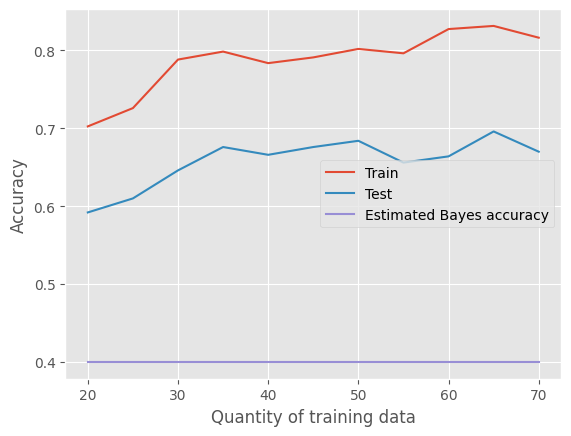

In [23]:
# Add this estimation to the plot of train/test error
# This is constant: you should add a horizontal line to your graph
# Plot the results
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.plot(sizes, [1 - np.around(expectation, 3) for x in sizes], label='Estimated Bayes accuracy')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

## Error versus complexity

**11)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

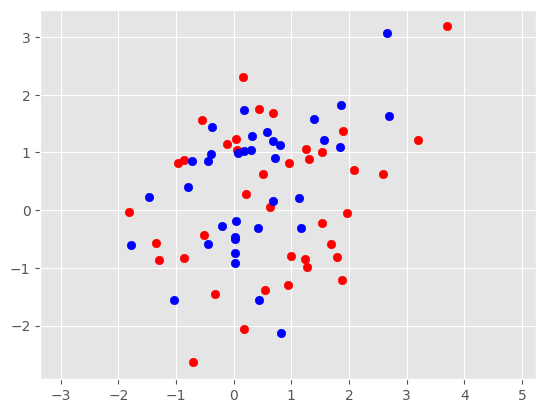

In [24]:
# Modify the class of some data points randomly
n_noise = 50
n_tr = len(y_train)
idx = np.random.choice(range(n_tr), n_noise)
y_train[idx] = 1 - y_train[idx]

pos = np.where(y_train == 1)[0]
neg = np.where(y_train == 0)[0]

# Visualise the data
plt.scatter(X_train[pos,0], X_train[pos,1], c='r')
plt.scatter(X_train[neg,0], X_train[neg,1], c='b')
plt.axis('equal')
plt.show()

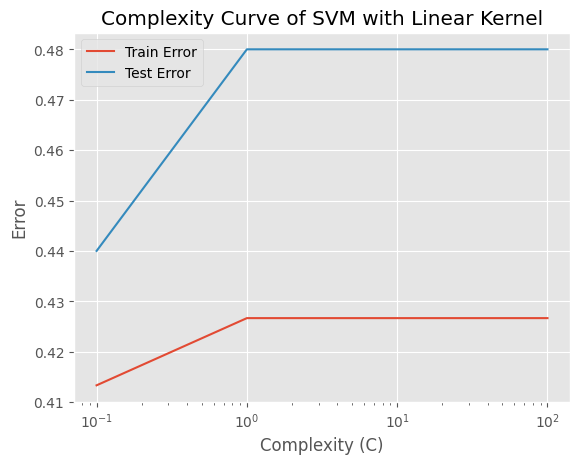

In [25]:
from sklearn.metrics import accuracy_score
# Vary the appropriate parameter and plot the training/testing results

complexity_values = [0.1, 1, 10, 100]
train_errors = []
test_errors = []

for complexity in complexity_values:
    # Create SVM classifier with the specified complexity
    svm = SVC(kernel='linear', C=complexity)
    
    # Fit the classifier on the noisy training data
    svm.fit(X_train, y_train)
    
    # Predict labels on the training and test data
    y_train_pred = svm.predict(X_train)
    y_test_pred = svm.predict(X_test)
    
    # Compute train and test errors
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    
    # Store errors
    train_errors.append(train_error)
    test_errors.append(test_error)

# Plot the complexity curves
plt.plot(complexity_values, train_errors, label='Train Error')
plt.plot(complexity_values, test_errors, label='Test Error')
plt.xlabel('Complexity (C)')
plt.ylabel('Error')
plt.xscale('log')
plt.title('Complexity Curve of SVM with Linear Kernel')
plt.legend()
plt.show()